In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy
import time
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import models
from gensim import corpora
from collections import defaultdict
from collections import Counter
import jieba.posseg as jp
import jieba.analyse
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# k1=0.5  #名词 'n' 
# k2=0.4  #动词 'v' 
# k3=0.3  #形容词/副词 'a' 'd' 
# k4=0.2  # 其他词性

k1=np.arange(0.5,1,0.1)  #名词 'n' 
k2=np.arange(0.4,1,0.1)  #动词 'v' 
k3=np.arange(0.3,1,0.1)  #形容词/副词 'a' 'd'
k4=np.arange(0.2,1,0.1)  # 其他词性

k_tuple=[]
for k_1 in k1:
    for k_2 in k2:
        for k_3 in k3:
            for k_4 in k4:
                if k_1>k_2 and k_2>k_3 and k_3>k_4:
                    k_tuple.append((k_1,k_2,k_3,k_4))

k_tuple=[(1,1,1,1)]

delta_k=0.1 #词性权重步长
flag_en2cn = {
    'a': '形容词', 'ad': '副形词', 'ag': '形语素', 'an': '名形词', 'b': '区别词',
    'c': '连词', 'd': '副词', 'df': '不要', 'dg': '副语素',
    'e': '叹词', 'f': '方位词', 'g': '语素', 'h': '前接成分',
    'i': '成语', 'j': '简称略语', 'k': '后接成分', 'l': '习用语',
    'm': '数词', 'mg': '数语素', 'mq': '数量词',
    'n': '名词', 'ng': '名语素', 'nr': '人名', 'nrfg': '古代人名', 'nrt': '音译人名',
    'ns': '地名', 'nt': '机构团体', 'nz': '其他专名',
    'o': '拟声词', 'p': '介词', 'q': '量词',
    'r': '代词', 'rg': '代语素', 'rr': '代词', 'rz': '代词',
    's': '处所词', 't': '时间词', 'tg': '时间语素',
    'u': '助词', 'ud': '得', 'ug': '过', 'uj': '的', 'ul': '了', 'uv': '地', 'uz': '着',
    'v': '动词', 'vd': '副动词', 'vg': '动语素', 'vi': '动词', 'vn': '名动词', 'vq': '动词',
    'x': '非语素字', 'y': '语气词', 'z': '状态词', 'zg': '状态语素',
}

n_list=['n', 'ng', 'nr', 'nrfg', 'nrt','ns', 'nt', 'nz']  #广义名词词性
v_list=['v', 'vd', 'vg', 'vi', 'vn', 'vq'] #广义动词词性
a_list=['a','ad','ag','an']  #广义形容词词性
d_list=['d','df','dg']  #广义副词词性


mark_punctuate=['，','。','？','……','”','“'] #去除语料标点
stop_words=[]  #停用词
with open('./中文停用词.txt','r',encoding='utf-8') as f:
    stop_words.append(f.readlines())
stop_words=stop_words[0]


"语料预处理"
def preprocess_str(te):
    text=te
    if ":" in text:
        text=text.split(":")[1]
    if '：' in text:
        text=text.split('：')[1]
    words=[w.word for w in jp.lcut(text) if w.word not in mark_punctuate and '\u4e00' <= w.word <= '\u9fff' and w.word not in stop_words] #Jieba中文分词处理
    word_class=[w.flag for w in jp.lcut(text) if w.word not in mark_punctuate and '\u4e00' <= w.word <= '\u9fff' and w.word not in stop_words] 
    
    return zip(words,word_class)

"统计词频"
def frequency_stats(zip_word):
    frequency=defaultdict(int)
    word_list=list(zip_word)
    for word in word_list:
        frequency[word]+=1
    return frequency

"词性权重"
def weight(word_class,delta_k=0):
    if word_class in n_list:
        return k1+delta_k
    elif word_class in v_list:
        return k2+delta_k
    elif word_class in a_list or word_class in d_list:
        return k3+delta_k
    else:
        return k4+delta_k

"词性权重"
def weight_(word_class,k_tuple):
    if word_class in n_list:
        return k_tuple[0]
    elif word_class in v_list:
        return k_tuple[1]
    elif word_class in a_list or word_class in d_list:
        return k_tuple[2]
    else:
        return k_tuple[3]
    
    
    
    

"词性加权TFIDF"
def get_weighted_word_tfidf(corpus_tfidf,delta_k):
    word_t_tfidf=[]  #统计第t个关键词tfidf
    for i in range(len(corpus_tfidf)):
        for m in range(len(corpus_tfidf[i])):
            id_tfidf=corpus_tfidf[i][m]
            word=id2word[id_tfidf[0]]
            word_class=corpus_pair[i][corpus[i].index(word)][1]
            corpus_tfidf[i][m]=(id_tfidf[0],id_tfidf[1]*weight(word_class,delta_k))     
            if id_tfidf[0]==word_tid:
                word_t_tfidf.append(id_tfidf[1]*weight(word_class,delta_k))  #找到第t个关键词对应的加权tfidf值
    word_t_tfidf=np.sum(word_t_tfidf)     #给定第t个词加权tfidf值
    return word_t_tfidf,corpus_tfidf

def get_weighted_word_tfidf_(corpus_tfidf,k_tuple):
    word_t_tfidf=[]  #统计第t个关键词tfidf
    for i in range(len(corpus_tfidf)):
        for m in range(len(corpus_tfidf[i])):
            id_tfidf=corpus_tfidf[i][m]
            word=id2word[id_tfidf[0]]
            word_class=corpus_pair[i][corpus[i].index(word)][1]
            corpus_tfidf[i][m]=(id_tfidf[0],id_tfidf[1]*weight_(word_class,k_tuple))     
            if id_tfidf[0]==word_tid:
                word_t_tfidf.append(id_tfidf[1]*weight_(word_class,k_tuple))  #找到第t个关键词对应的加权tfidf值
    word_t_tfidf=np.sum(word_t_tfidf)     #给定第t个词加权tfidf值
    return word_t_tfidf,corpus_tfidf

def plot_JS(lda,n_topics=25):
    "计算主题JS距离方差"
    divergence=[]
    for k in range(2,n_topics+1):
        var=d=0
        topics_terms=lda.state.get_lambda()
        topics_terms_proba = np.apply_along_axis(lambda x: x/x.sum(),1,topics_terms)
        # 计算主题方差
        for t in range(k):
                for c in range(t, k):
                    proba_m=(topics_terms_proba[t]+topics_terms_proba[c])/2
                    js=0.5*scipy.stats.entropy(topics_terms_proba[t],proba_m)+ 0.5*scipy.stats.entropy(topics_terms_proba[c],proba_m) #计算JS距离
                    var += js
                    d += 1
        var_std = round(var / (k*d), 2)
        divergence.append(var_std)
    plt.figure(figsize=(15, 10))
    plt.plot(list(range(2, n_topics+1)), divergence, color='green')
    plt.scatter(list(range(2, n_topics+1)), divergence, color='red')
    plt.xticks(list(range(2, n_topics+1)))
    plt.xlabel('LDA主题数',fontproperties='SimHei')
    plt.ylabel('LDA主题JS距离方差',fontproperties='SimHei')   
    return divergence

"--------------------------------------------LDA/TFIDF+LDA模型实验-------------------------------------"

"导入语料"
text=pd.read_excel("./参考语料库.xlsx")
corpus=[]  #分词
corpus_class=[] #词性标注
for line in text['评论内容'].tolist():
    if type(line)==str :
       zip_word=preprocess_str(line)
       frequency=frequency_stats(zip_word)
       corpus.append([key[0] for key in frequency if frequency[key] >=1 and len(key[0])>1])
       corpus_class.append([key[1] for key in frequency if frequency[key] >=1 and len(key[0])>1])

corpus=[word_list for word_list in corpus if len(word_list)>1]
corpus_class=[class_list for class_list in corpus_class if len(class_list)>1]
corpus_pair=[list(zip(corpus[i],corpus_class[i])) for i in range(len(corpus))]
"词袋模型"
dictionary=corpora.Dictionary(corpus)
word2id=dictionary.token2id #所有分词和对应索引
id2word={list(word2id.values())[i]:list(word2id.keys())[i] for i in range(len(list(word2id.keys())))} #键值互换
bow_corpus=[dictionary.doc2bow(text) for text in corpus]
"关键词词频和给定语义ωt计算"
corpus_df=pd.DataFrame({'cut_word':np.array(corpus)})
corpus_df['cut_word']=corpus_df['cut_word'].apply(lambda x:" ".join(x))
jieba.analyse.set_stop_words('./中文停用词.txt')
te=''
for i in range(len(corpus_df['cut_word'])):
    if len(corpus_df['cut_word'][i])>0:
     te+=corpus_df['cut_word'][i]+'\n'
c=Counter()
stat=0
for word in te.split():
    c[word]+=1
for word in c:
    if c[word]==1:
        stat+=1
t=int((math.sqrt(1+8*stat)-1)/2)
keyword_list=jieba.analyse.extract_tags(te,topK=1000,withWeight=True) #关键词词频
word_t=keyword_list[t-1]  #第t个关键词
word_tid=word2id[word_t[0]]  #第t个关键词索引

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='

In [2]:
"Gibbs采样——BTM"
def gibbs_BTM(It, V, B,num_topics, b, alpha=50., beta=0.01):
  print("Biterm model ------ ")
  print("Corpus length: " + str(len(b)))
  print("Number of topics: " + str(num_topics))
  print("alpha: " + str(alpha) + " beta: " + str(beta))

  Z =  np.zeros(B)
  Nwz = np.zeros((V, num_topics))
  Nz = np.zeros(num_topics)

  theta = np.random.dirichlet([alpha]*num_topics, 1)
  #gibbs采样初始化
  for ibi, bi in enumerate(b):
     
      topics = np.random.choice(num_topics, 1, p=theta[0,:])[0]
      Nwz[bi[0], topics] += 1
      Nwz[bi[1], topics] += 1
      Nz[topics] += 1
      Z[ibi] = topics
  Z=Z.astype('int32')
  #gibbs采样
  for it in range(It):
      print("Iteration: " + str(it))
      Nzold = np.copy(Nz)
      for ibi, bi in enumerate(b):
          Nwz[bi[0], Z[ibi]] -= 1
          Nwz[bi[1], Z[ibi]] -= 1
          Nz[Z[ibi]] -= 1
          pz = (Nz + alpha)*(Nwz[bi[0],:]+beta)*(Nwz[bi[1],:]+beta)/(Nwz.sum(axis=0)+beta*V)**2
          pz = pz/pz.sum()
          Z[ibi] = np.random.choice(num_topics, 1, p=pz)
          Nwz[bi[0], Z[ibi]] += 1
          Nwz[bi[1], Z[ibi]] += 1
          Nz[Z[ibi]] += 1
      print("Variation between iterations:  " + str(np.sqrt(np.sum((Nz-Nzold)**2))))
  return Nz, Nwz, Z


"Gibbs采样——TFIDF+BTM"
def gibbs_TFIDF_BTM(It, V, B,dictionary,word_tfidf,word_t_tfidf,num_topics, b, alpha=50., beta=0.01,λ=1):
    print("Biterm model ------ ")
    print("Corpus length: " + str(len(b)))
    print("Number of topics: " + str(num_topics))
    print("alpha: " + str(alpha) + " beta: " + str(beta))

    Z =  np.zeros(B)
    Nwz = np.zeros((V, num_topics))
    Nz = np.zeros(num_topics)
    q=0 #统计增加词对的数量
    theta = np.random.dirichlet([alpha]*num_topics, 1)
    #gibbs采样初始化
    for ibi, bi in enumerate(b): 
        word=dictionary[bi[0]]
        topics = np.random.choice(num_topics, 1, p=theta[0,:])[0]
        if word_tfidf[word]>word_t_tfidf: #ωa＞ωt
          Nwz[bi[0],topics]+=1+λ
          Nwz[bi[1],topics]+=1+λ
          Nz[topics] += 1+λ
          q+=1  #统计增加词对的数量
        else:
            Nwz[bi[0], topics] += 1
            Nwz[bi[1], topics] += 1
            Nz[topics] += 1
        Z[ibi] = topics
    Z=Z.astype('int32')
    #gibbs采样
    for it in range(It):
        print("Iteration: " + str(it))
        Nzold = np.copy(Nz)
        for ibi, bi in enumerate(b):
            Nwz[bi[0], Z[ibi]] -= 1
            Nwz[bi[1], Z[ibi]] -= 1
            Nz[Z[ibi]] -= 1
            word=dictionary[bi[0]]
            if word_tfidf[word]>word_t_tfidf: #ωa＞ωt 依据ωa与给定的语义距离值ωt之间的距离关系
              pz = (Nz + alpha)*(Nwz[bi[0],:]+beta+word_tfidf[word]*λ)*(Nwz[bi[1],:]+beta+word_tfidf[word]*λ)/(Nwz.sum(axis=0)+beta*V+2*word_tfidf[word]*λ)**2
              pz = pz/pz.sum()
              Z[ibi] = np.random.choice(num_topics, 1, p=pz)
              Nwz[bi[0], Z[ibi]] += 1
              Nwz[bi[1], Z[ibi]] += 1
              Nz[Z[ibi]] += 1
            else:
                pz = (Nz + alpha)*(Nwz[bi[0],:]+beta)*(Nwz[bi[1],:]+beta)/(Nwz.sum(axis=0)+beta*V)**2
                pz = pz/pz.sum()
                Z[ibi] = np.random.choice(num_topics, 1, p=pz)
                Nwz[bi[0], Z[ibi]] += 1
                Nwz[bi[1], Z[ibi]] += 1
                Nz[Z[ibi]] += 1
        print("Variation between iterations:  " + str(np.sqrt(np.sum((Nz-Nzold)**2))))
    return Nz, Nwz, Z,q

def pbd(doc,names):
    ret = []
    retnames = []
    for term1 in set(doc):
        cnts = 0.
        for term2 in doc:
            if term1 == term2:
                cnts +=1.
        ret.append(cnts/len(doc))
        retnames.append(term1)
    if names:
        return retnames
    else:
        return ret
#计算单词词性加权tfidf
def  weighted_tfidf(texts,dictionary,corpus_pair,delta_k):
    count={}
    sentence={}
    #统计词频
    for i in range(len(dictionary)):
        word=dictionary[i]
        count[word]=0
        sentence[word]=0
        for text in texts:
          if word in text:
              sentence[word]+=1
          for w in text:
                if word==w:
                    count[word]+=1
   
    freq_word={word:count[word]/sum(count.values()) for word in count}
    idf_word={word:math.log(len(texts)/ (1+sentence[word])) for word in sentence}
    tfidf_word={word: freq_word[word] * idf_word[word] for word in freq_word }
    corpus_pair_list=[]
    for pair in corpus_pair:
        corpus_pair_list.extend(pair)
    word_type_dict=dict(corpus_pair_list)
    
    weighted_word_tfidf={word:tfidf_word[word]* weight(word_type_dict[word],delta_k) for word in tfidf_word}
    
    return weighted_word_tfidf

def  weighted_tfidf_(texts,dictionary,corpus_pair,k_tuple):
    count={}
    sentence={}
    #统计词频
    for i in range(len(dictionary)):
        word=dictionary[i]
        count[word]=0
        sentence[word]=0
        for text in texts:
          if word in text:
              sentence[word]+=1
          for w in text:
                if word==w:
                    count[word]+=1
   
    freq_word={word:count[word]/sum(count.values()) for word in count}
    idf_word={word:math.log(len(texts)/ (1+sentence[word])) for word in sentence}
    tfidf_word={word: freq_word[word] * idf_word[word] for word in freq_word }
    corpus_pair_list=[]
    for pair in corpus_pair:
        corpus_pair_list.extend(pair)
    word_type_dict=dict(corpus_pair_list)
    
    weighted_word_tfidf={word:tfidf_word[word]* weight_(word_type_dict[word],k_tuple) for word in tfidf_word}
    
    return weighted_word_tfidf

def topTopic(Nwz,model,q,word_tfidf,λ=1,num_topics=25):
      topics =  [[dictionary[ident] for ident in np.argsort(-Nwz[:,k])[0:10]] for k in range(num_topics)]
      print("TOP 10 words per topic")
      topic_tfidf=[]
      for topic in topics:
          tfidf=0
          print(topic)
          print ("  ---- ")
          for word in topic:
              tfidf+=word_tfidf[word]*λ  #K个主题中单词wa的tfidf值与λ的乘积累加
          topic_tfidf.append(tfidf)
      topic_tfidf=np.array(topic_tfidf) 
      if  model=='btm':
        thetaz = (Nz + alpha)/(B + num_topics*alpha)
        phiwz = (Nwz + beta)/np.tile((Nwz.sum(axis=0)+V*beta),(V,1))
      else:  
          thetaz = (Nz + alpha+topic_tfidf)/(B + num_topics*alpha+q)
          phiwz = (Nwz + beta+topic_tfidf)/np.tile((Nwz.sum(axis=0)+V*beta+2*topic_tfidf),(V,1))

      pzb = [[list(thetaz*phiwz[term[0],:]*phiwz[term[1],:]/(thetaz*phiwz[term[0],:]*phiwz[term[1],:]).sum()) for term in set(doc)] for doc in btmp]

      return phiwz,topics,pzb


"计算BTM模型主题一致性"
def coherence(P_wz,dictionary, M):
   
    coherence=[0] * len(P_wz)  
    for z, P_wzi in enumerate(P_wz):
        V_z = np.argsort(P_wzi)[:-(M + 1):-1]
        W_z = dictionary[V_z]
        C_z = 0
        for m in range(1, M):
            for l in range(m):
                D_vmvl = np.in1d(np.nonzero(X[:,V_z[l]]), np.nonzero(X[:,V_z[m]])).sum(dtype=int) + 1
                D_vl = np.count_nonzero(X[:,V_z[l]])
                if D_vl != 0:
                    C_z += math.log(D_vmvl / D_vl)

        coherence[z] = C_z
    return coherence

"计算BTM主题模型JS距离方差"
def plot_js_btm(phiwz,n_topics=25):
    divergence=[]
    for k in range(2,n_topics+1):
        var=d=0
        # 计算主题方差
        for t in range(k):
                for c in range(t, k):
                    proba_m=(phiwz[t]+phiwz[c])/2
                    js=0.5*scipy.stats.entropy(phiwz[t],proba_m)+ 0.5*scipy.stats.entropy(phiwz[c],proba_m) #计算JS距离
                    var += js
                    d += 1
        var_std = round(var / (k*d), 2)
        divergence.append(var_std)
    plt.figure(figsize=(15, 10))
    plt.plot(list(range(2, n_topics+1)), divergence, color='green')
    plt.scatter(list(range(2, n_topics+1)), divergence, color='red')
    plt.xticks(list(range(2, n_topics+1)))
    plt.xlabel('BTM主题数',fontproperties='SimHei')
    plt.ylabel('BTM主题JS距离方差',fontproperties='SimHei')    
    return divergence

Biterm model ------ 
Corpus length: 989733
Number of topics: 25
alpha: 50.0 beta: 0.01
Iteration: 0
Variation between iterations:  1820.1807602543215
Iteration: 1
Variation between iterations:  2150.5957314195525
Iteration: 2
Variation between iterations:  2392.7156120191135
Iteration: 3
Variation between iterations:  2739.812767325534
Iteration: 4
Variation between iterations:  2362.783104730521
Iteration: 5
Variation between iterations:  2722.288375613429
Iteration: 6
Variation between iterations:  2917.3974703492154
Iteration: 7
Variation between iterations:  3575.3273975959182
Iteration: 8
Variation between iterations:  3378.6828794664943
Iteration: 9
Variation between iterations:  3406.151787574946
Iteration: 10
Variation between iterations:  3005.0384356942923
Iteration: 11
Variation between iterations:  2977.6742602239083
Iteration: 12
Variation between iterations:  3398.239838504634
Iteration: 13
Variation between iterations:  3006.6679231335143
Iteration: 14
Variation between 

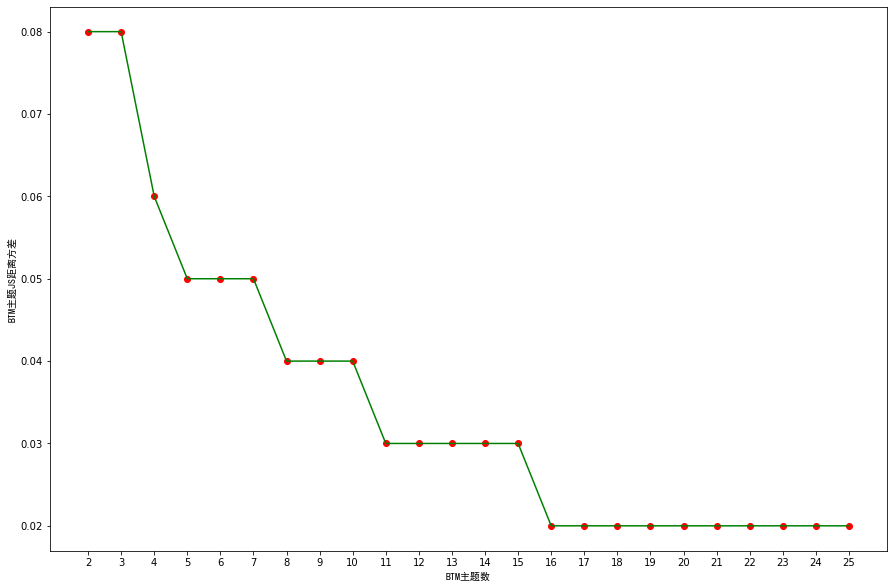

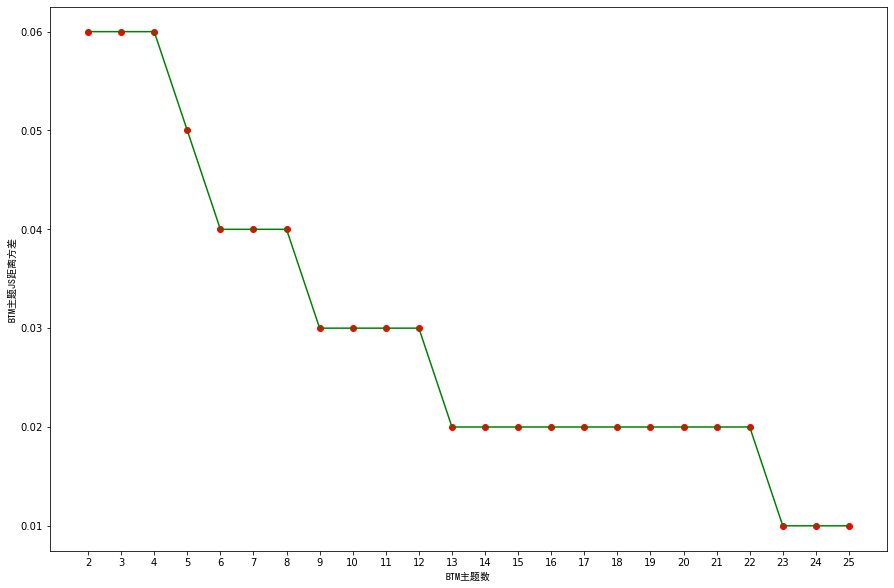

In [3]:
alpha = 50.
beta = 0.01  
num_topics = 25
"BTM/TFIDF+BTM模型训练"    
texts=corpus_df.cut_word.tolist() #导入文本生成词组列表
vec= TfidfVectorizer(stop_words=stop_words)
X= CountVectorizer(stop_words=stop_words).fit_transform(texts).toarray()
texts=[text.split() for text in texts]
N = len(texts)
dictionary = np.array(list(set([word for text in texts for word in text]))) 
V = len(dictionary)

coh_btm=[]
coh_btm_tfidf=[]
js_btm=[]
js_btm_tfidf=[]
iteration=100
step=1
#start_btm=time.time()
for i in range(step):
    for k in k_tuple:  
      delta_λ=5
      tfidf=models.TfidfModel(bow_corpus)  
      corpus_tfidf=[tfidf[doc] for doc in bow_corpus]
      word_t_tfidf,_=get_weighted_word_tfidf_(corpus_tfidf,k) #第t个关键词词性加权tfidf
      word_tfidf= weighted_tfidf_(texts,dictionary,corpus_pair,k) #计算所有词组词性加权tfidf
      btmp = [[(np.where(dictionary==word1)[0][0], np.where(dictionary==word2)[0][0])
         for iword1, word1 in enumerate(text) for iword2, word2 in enumerate(text)
         if iword1 < iword2] for text in texts] #生成biterms
      aux = []
      for bi in btmp:
        aux.extend(bi)
      b = aux  #biterm数组
      B = len(b)
      bset = set(b)
      pbd_cts = [pbd(doc, False) for doc in btmp]
      pbd_names = [pbd(doc, True) for doc in btmp]
      Nz, Nwz, Z = gibbs_BTM(It=iteration, V=V, B=B, num_topics=num_topics, b=b, alpha=alpha, beta=beta) #btm
      Nz_td,Nwz_td,Z_td,q=gibbs_TFIDF_BTM(iteration, V, B,dictionary, word_tfidf,word_t_tfidf,num_topics, b, alpha=50., beta=0.01,λ=delta_λ)  #tfidf+btm
      phiwz,topic,pzb= topTopic(Nwz,'btm',q,word_tfidf,λ=delta_λ,num_topics=25) 
      phiwz_td,topic_td,pzb_td=topTopic(Nwz_td,'tfidf_btm',q,word_tfidf,λ=delta_λ,num_topics=25)


      coh_btm.append(coherence(phiwz.T,dictionary, num_topics))
      coh_btm_tfidf.append(coherence(phiwz_td.T,dictionary, num_topics))
       
      js_btm.append(plot_js_btm(phiwz.T,num_topics))
      js_btm_tfidf.append(plot_js_btm(phiwz_td.T,num_topics))
      
      #end_btm=time.time()
      #if end_btm-start_btm>=3600:
      #    break
    
coh_btm_array=np.array(coh_btm)    
coh_btm_tfidf_array=np.array(coh_btm_tfidf)   
js_btm_array=np.array(js_btm)   
js_btm_tfidf_array=np.array(js_btm_tfidf)

In [5]:
print("btm_tfidf topic=25")
step=1
i=0
for i in range(step):
    arr=np.array(js_btm_tfidf_array[i])
    total = arr.sum()
    avg = np.average(arr)
    #print(total)
    print(avg)
    
step=1
i=0
for i in range(step):
    arr=np.array(coh_btm_tfidf_array[i])
    total = arr.sum()
    avg = np.average(arr)
    #print(total)
    print(avg)    
    

print("btm topic=25")
step=1
i=0
for i in range(step):
    arr=np.array(js_btm_array[i])
    total = arr.sum()
    avg = np.average(arr)
    #print(total)
    print(avg)
    
step=1
i=0
for i in range(step):
    arr=np.array(coh_btm_array[i])
    total = arr.sum()
    avg = np.average(arr)
    #print(total)
    print(avg)    

btm_tfidf topic=25
0.02916666666666667
-422.50234429041296
btm topic=25
0.035
-430.2427291764135


In [22]:
coh_btm_array[0]

array([ 20.26246808, -25.3973197 , -46.03392969,  -9.49672504,
        59.91691137, -37.57934691,  25.93492735,  16.59002739,
       -10.74390975,  38.16488542,  41.94122032, -11.31252995,
        95.07007869,  17.96230891, -19.33291923,  30.84425437,
       -44.7825327 ,  32.59744888,  50.61814706,  16.15988614])

In [ ]:
"计算BTM主题模型JS距离方差"
def plot_js_btm(phiwz,n_topics=25):
    divergence=[]
    JS=[]
    for k in range(2,n_topics+1):
        var=d=0
        # 计算主题方差
        for t in range(k):
                for c in range(t, k):
                    proba_m=(phiwz[t]+phiwz[c])/2
                    js=0.5*scipy.stats.entropy(phiwz[t],proba_m)+ 0.5*scipy.stats.entropy(phiwz[c],proba_m) #计算JS距离
                    JS.append(js)
                    var += js
                    d += 1
        var_std = round(var / (k*d), 2)
        divergence.append(var_std)
    plt.figure(figsize=(15, 10))
    plt.plot(list(range(2, n_topics+1)), divergence, color='green')
    plt.scatter(list(range(2, n_topics+1)), divergence, color='red')
    plt.xticks(list(range(2, n_topics+1)))
    plt.xlabel('BTM主题数',fontproperties='SimHei')
    plt.ylabel('BTM主题JS距离方差',fontproperties='SimHei')    
    return divergence,JS

In [ ]:
alpha = 50.
beta = 0.01  
num_topics = 25
"BTM/TFIDF+BTM模型训练"    
texts=corpus_df.cut_word.tolist() #导入文本生成词组列表
vec= TfidfVectorizer(stop_words=stop_words)
X= CountVectorizer(stop_words=stop_words).fit_transform(texts).toarray()
texts=[text.split() for text in texts]
N = len(texts)
dictionary = np.array(list(set([word for text in texts for word in text]))) 
V = len(dictionary)

coh_btm=[]
coh_btm_tfidf=[]
js_btm=[]
js_btm_tfidf=[]
iteration=100
step=1
#start_btm=time.time()
for i in range(step):
    for k in k_tuple:  
      delta_λ=5
      tfidf=models.TfidfModel(bow_corpus)  
      corpus_tfidf=[tfidf[doc] for doc in bow_corpus]
      word_t_tfidf,_=get_weighted_word_tfidf_(corpus_tfidf,k) #第t个关键词词性加权tfidf
      word_tfidf= weighted_tfidf_(texts,dictionary,corpus_pair,k) #计算所有词组词性加权tfidf
      btmp = [[(np.where(dictionary==word1)[0][0], np.where(dictionary==word2)[0][0])
         for iword1, word1 in enumerate(text) for iword2, word2 in enumerate(text)
         if iword1 < iword2] for text in texts] #生成biterms
      aux = []
      for bi in btmp:
        aux.extend(bi)
      b = aux  #biterm数组
      B = len(b)
      bset = set(b)
      pbd_cts = [pbd(doc, False) for doc in btmp]
      pbd_names = [pbd(doc, True) for doc in btmp]
      Nz, Nwz, Z = gibbs_BTM(It=iteration, V=V, B=B, num_topics=num_topics, b=b, alpha=alpha, beta=beta) #btm
      Nz_td,Nwz_td,Z_td,q=gibbs_TFIDF_BTM(iteration, V, B,dictionary, word_tfidf,word_t_tfidf,num_topics, b, alpha=50., beta=0.01,λ=delta_λ)  #tfidf+btm
      phiwz,topic,pzb= topTopic(Nwz,'btm',q,word_tfidf,λ=delta_λ,num_topics=25) 
      phiwz_td,topic_td,pzb_td=topTopic(Nwz_td,'tfidf_btm',q,word_tfidf,λ=delta_λ,num_topics=25)


      coh_btm.append(coherence(phiwz.T,dictionary, num_topics))
      coh_btm_tfidf.append(coherence(phiwz_td.T,dictionary, num_topics))
      _,JS_BTM=plot_js_btm(phiwz.T,num_topics)
      _,JS_BTM_TFIDF=plot_js_btm(phiwz.T,num_topics)
      js_btm.append(JS_BTM)
      js_btm_tfidf.append(JS_BTM_TFIDF)
      
      #end_btm=time.time()
      #if end_btm-start_btm>=3600:
      #    break
    
coh_btm_array=np.array(coh_btm)    
coh_btm_tfidf_array=np.array(coh_btm_tfidf)   
js_btm_array=np.array(js_btm)   
js_btm_tfidf_array=np.array(js_btm_tfidf)